In [1]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, TimeDistributed
import numpy as np
from collections import Counter, defaultdict
from tensorflow.keras.preprocessing import image
from PIL import ImageDraw

from scipy.misc import imread, imresize, imsave, fromimage, toimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

In [2]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    x = x.copy()
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
base_model = vgg16.VGG16(weights='imagenet', include_top=True)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [4]:
cat_dog = preprocess_image('data/cat_dog.jpg', target_size=(224, 224))
preds = base_model.predict(cat_dog)
print('Predicted:', vgg16.decode_predictions(preds, top=3)[0])

Predicted: [('n02099601', 'golden_retriever', 0.099326335), ('n02100735', 'English_setter', 0.053414322), ('n02106662', 'German_shepherd', 0.048760593)]


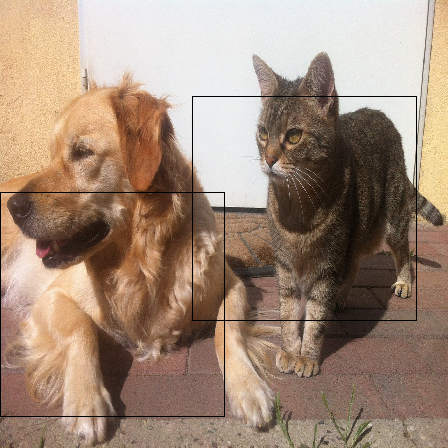

In [5]:
cat_dog_img = image.load_img('data/cat_dog.jpg', target_size=(448, 448))
draw = ImageDraw.Draw(cat_dog_img)
draw.rectangle((192, 96, 416, 320), outline=(0, 0, 0))
draw.rectangle((0, 192, 224, 416), outline=(0, 0, 0))
cat_dog_img

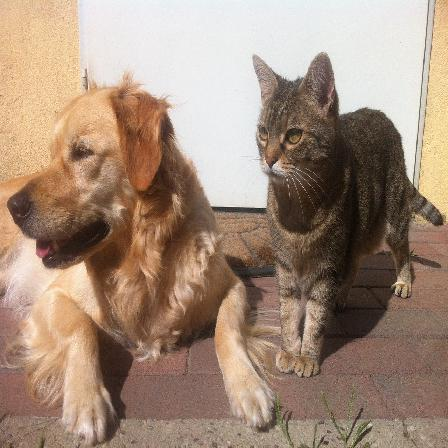

In [6]:
cat_dog2 = preprocess_image('data/cat_dog.jpg', target_size=(448, 448))
showarray(deprocess_image(cat_dog2, 448, 448))

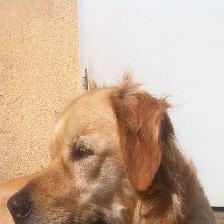

In [7]:
crops = []
for x in range(7):
    for y in range(7):
        crops.append(cat_dog2[0, x * 32: x * 32 + 224, y * 32: y * 32 + 224, :])
crops = np.asarray(crops)
showarray(deprocess_image(crops[0], 224, 224))

In [8]:
preds = base_model.predict(vgg16.preprocess_input(crops))
crop_scores = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(preds, top=1)):
    _, label, weight = pred[0]
    crop_scores[label].append((idx, weight))
crop_scores.keys()

dict_keys(['Labrador_retriever', 'Norwegian_elkhound', 'tiger_cat', 'Egyptian_cat', 'tabby', 'kuvasz', 'flat-coated_retriever', 'standard_schnauzer'])

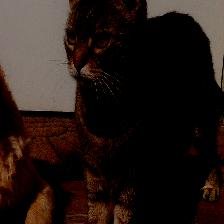

In [9]:
def best_image_for_label(l, label):
    idx = max(l[label], key=lambda t:t[1])[0]
    return deprocess_image(crops[idx], 224, 224)

showarray(best_image_for_label(crop_scores, 'Egyptian_cat'))

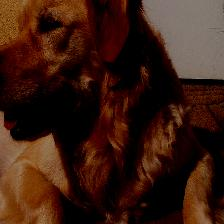

In [10]:
showarray(best_image_for_label(crop_scores, 'Labrador_retriever'))

In [11]:
def create_top_model(base_model):
    inputs = Input(shape=(7, 7, 512), name='input')
    flatten = Flatten(name='flatten')(inputs)
    fc1 = Dense(4096, activation='relu', name='fc1')(flatten)
    fc2 = Dense(4096, activation='relu', name='fc2')(fc1)
    predictions = Dense(1000, activation='softmax', name='predictions')(fc2)
    model = Model(inputs, predictions, name='top_model')
    for layer in model.layers:
        if layer.name != 'input':
            print(layer.name)
            layer.set_weights(base_model.get_layer(layer.name).get_weights())
    return model

top_model = create_top_model(base_model)
top_model.summary()

flatten
fc1
fc2
predictions
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 7, 7, 512)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 1000)              4097000   
Total params: 123,642,856
Trainable params: 123,642,856
Non-trainable params: 0
_________________________________________________________________


In [12]:
bottom_model = vgg16.VGG16(weights='imagenet', include_top=False)
bottom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
p0 = base_model.predict(crops[:1])
vgg16.decode_predictions(p0, top=1)

[[('n02099601', 'golden_retriever', 0.4088551)]]

In [14]:
b0 = bottom_model.predict(crops[:1])
t0 = top_model.predict(b0[:, :, :, :])
vgg16.decode_predictions(t0, top=1)

[[('n02099601', 'golden_retriever', 0.4088551)]]

In [15]:
bottom_out = bottom_model.predict(cat_dog2)
bottom_out.shape

(1, 14, 14, 512)

In [16]:
vec_crops = []
for x in range(7):
    for y in range(7):
        vec_crops.append(bottom_out[0, x: x + 7, y: y + 7, :])
vec_crops = np.asarray(vec_crops)
vec_crops.shape

(49, 7, 7, 512)

In [17]:
t0 = top_model.predict(vec_crops[:1])
vgg16.decode_predictions(t0, top=1)

[[('n02099601', 'golden_retriever', 0.3582282)]]

In [18]:
b0.shape

(1, 7, 7, 512)

In [19]:
crop_pred = top_model.predict(vec_crops)
l = defaultdict(list)
for idx, pred in enumerate(vgg16.decode_predictions(crop_pred, top=1)):
    _, label, weight = pred[0]
    l[label].append((idx, weight))
l.keys()

dict_keys(['golden_retriever', 'tennis_ball', 'tabby', 'tiger_cat', 'Rhodesian_ridgeback', 'Egyptian_cat', 'German_shepherd'])

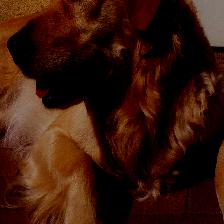

In [20]:
showarray(best_image_for_label(l, 'golden_retriever'))

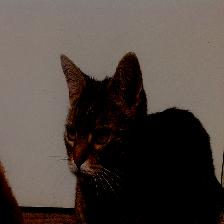

In [21]:
showarray(best_image_for_label(l, 'tabby'))

In [22]:
import sys
sys.path.append('../../../../../checkout/keras-frcnn')
import keras_frcnn, keras_frcnn.roi_helpers

import pickle
c = pickle.load(open('data/config.pickle', 'rb'))
c

ModuleNotFoundError: No module named 'keras_frcnn'

In [ ]:
import keras_frcnn.resnet as nn

num_features = 1024

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(c.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(c.anchor_box_scales) * len(c.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, c.num_rois, nb_classes=len(c.class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)


In [ ]:
model_rpn.load_weights('data/model_frcnn.hdf5', by_name=True)
model_classifier.load_weights('data/model_frcnn.hdf5', by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [ ]:
img = cv2.imread('data/cat_dog.jpg')

X, ratio = format_img(img, c)

if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))

y1, y2, f = model_rpn.predict(X)
r = keras_frcnn.roi_helpers.rpn_to_roi(y1, y2, c, K.image_dim_ordering(), overlap_thresh=0.7)
roi_count = R.shape[0] // c.num_rois
r2 = np.zeros((roi_count * c.num_rois, r.shape[1]))
r2 = r[:r2.shape[0],:r2.shape[1]]
r2 = np.reshape(r2, (roi_count, c.num_rois, r.shape[1]))


In [ ]:
idx_to_class = {v: k for k, v in c.class_mapping.items()}
bboxes = []

C = c
for jk in range(R.shape[0]//C.num_rois + 1):
		ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
		if ROIs.shape[1] == 0:
			break

		if jk == R.shape[0]//C.num_rois:
			#pad R
			curr_shape = ROIs.shape
			target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
			ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
			ROIs_padded[:, :curr_shape[1], :] = ROIs
			ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
			ROIs = ROIs_padded

		[P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

		for ii in range(P_cls.shape[1]):

			if np.max(P_cls[0, ii, :]) < 0.8 or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
				continue

			cls_name = idx_to_class[np.argmax(P_cls[0, ii, :])]

			(x, y, w, h) = ROIs[0, ii, :]

			cls_num = np.argmax(P_cls[0, ii, :])
			try:
				(tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
				tx /= C.classifier_regr_std[0]
				ty /= C.classifier_regr_std[1]
				tw /= C.classifier_regr_std[2]
				th /= C.classifier_regr_std[3]
				x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
			except:
				pass
			bboxes.append((
                cls_name, np.max(P_cls[0, ii, :]), C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)
                                ))
del C
                           
bboxes =  list(sorted(bboxes, key=lambda t:t[1], reverse=True))
print(bboxes[:5])

In [ ]:
r = keras_frcnn.roi_helpers.rpn_to_roi(Y1, Y2, c, K.image_dim_ordering(), overlap_thresh=0.7)
roi_count = R.shape[0] // c.num_rois
r2 = np.zeros((roi_count * c.num_rois, r.shape[1]))
r2 = r[:r2.shape[0],:r2.shape[1]]
r2 = np.reshape(r2, (roi_count, c.num_rois, r.shape[1]))
p_cls = []
p_regr = []
for i in range(r2.shape[0]):
    pred = model_classifier_only.predict([F, r2[i: i + 1]])
    p_cls.append(pred[0][0])
    p_regr.append(pred[1][0])
p_cls = np.asarray(p_cls)
p_regr = np.asarray(p_regr)
p_cls.shape, r2.shape, p_regr.shape

In [ ]:
boxes = []
w, h, _ = r2.shape
for x in range(w):
    for y in range(h):
        cls_idx = np.argmax(p_cls[x][y])
        if cls_idx == len(idx_to_class) - 1:
            continue
        reg = p_regr[x, y, 4 * cls_idx:4 * (cls_idx + 1)]
        params = list(r2[x][y])
        params += list(reg / c.classifier_regr_std)
        box = keras_frcnn.roi_helpers.apply_regr(*params)
        box = list(map(lambda i: i * c.rpn_stride, box))
        boxes.append((idx_to_class[cls_idx], p_cls[x][y][cls_idx], box))


In [ ]:
boxes2 = list(sorted(boxes, key=lambda t:t[1], reverse=True))
boxes2[:5]

In [ ]:
new_config = pickle.load(open('data/config.pickle', 'rb'))
new_nb_classes = len(new_config.class_mapping)
out = model_classifier_only.layers[-3].output
new_out_class = TimeDistributed(Dense(new_nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(new_nb_classes))(out)
new_out_regr = TimeDistributed(Dense(4 * (new_nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(new_nb_classes))(out)
new_classifer =  [new_out_class, new_out_regr]


In [ ]:
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))
shared_layers = nn.nn_base(img_input, trainable=True)

num_anchors = len(c.anchor_box_scales) * len(c.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(shared_layers, roi_input, c.num_rois, len(c.class_mapping), trainable=True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

model_rpn.load_weights('data/model_frcnn.hdf5', by_name=True)
model_classifier.load_weights('data/model_frcnn.hdf5', by_name=True)

In [ ]:
new_config = pickle.load(open('data/config.pickle', 'rb'))
new_nb_classes = len(new_config.class_mapping)
out = model_classifier_only.layers[-3].output
new_out_class = TimeDistributed(Dense(new_nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(new_nb_classes))(out)
new_out_regr = TimeDistributed(Dense(4 * (new_nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(new_nb_classes))(out)
new_classifer =  [new_out_class, new_out_regr]

In [ ]:
new_model_classifier = Model([img_input, roi_input], classifier)
new_model_rpn = Model(img_input, rpn[:2])

new_model_all = Model([img_input, roi_input], rpn[:2] + classifier)
new_model_all.save_weights('data/model_frcnn_new.hdf5')